# Lecture 5 - Evolution and quantum statistics of a quantum parameter amplifier

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from qutip import (about, basis, correlation_matrix_quadrature, destroy,
                   expect, logarithmic_negativity, mesolve, num, ptrace, qeye,
                   tensor, wigner, wigner_covariance_matrix)

%matplotlib inline

Parameters
----------

In [2]:
chi = 0.2
N1 = 75
N2 = 75

Operators and Hamiltonian
-------------------------

In [3]:
a = tensor(destroy(N1), qeye(N2))
na = tensor(num(N1), qeye(N2))
b = tensor(qeye(N1), destroy(N2))
nb = tensor(qeye(N1), num(N2))

In [4]:
H = -chi * (a * b + a.dag() * b.dag())

In [5]:
# start in the ground (vacuum) state
psi0 = tensor(basis(N1, 0), basis(N2, 0))

Evolution
---------

In [6]:
tlist = np.linspace(0, 10, 100)

In [7]:
c_ops = []

In [8]:
e_ops = []

In [9]:
output = mesolve(H, psi0, tlist, c_ops, e_ops)
output

Result object with sesolve data.
--------------------------------
states = True
num_collapse = 0

## Expectation values and standard deviations


In [10]:
na_e = np.zeros(tlist.shape)
na_s = np.zeros(tlist.shape)
nb_e = np.zeros(tlist.shape)
nb_s = np.zeros(tlist.shape)

for idx, psi in enumerate(output.states):
    na_e[idx] = expect(na, psi)
    na_s[idx] = expect(na * na, psi)
    nb_e[idx] = expect(nb, psi)
    nb_s[idx] = expect(nb * nb, psi)

# subtract the average squared to obtain variances
na_s = na_s - na_e**2
nb_s = nb_s - nb_e**2

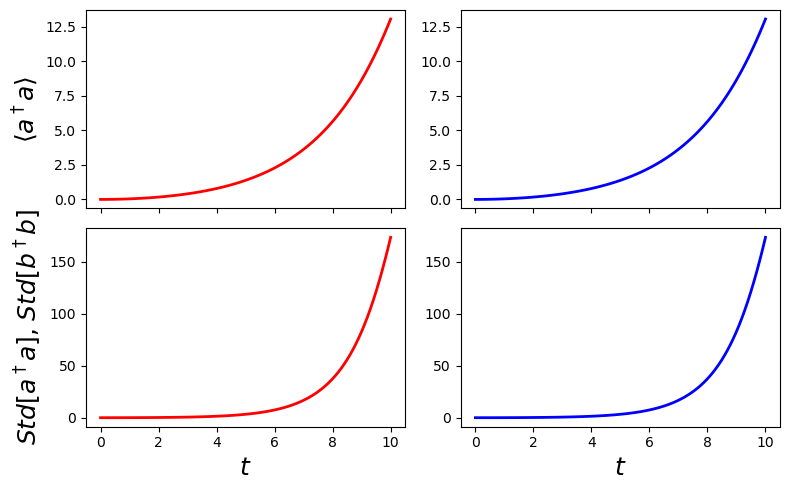

In [11]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(8, 5))

line1 = axes[0, 0].plot(tlist, na_e, "r", linewidth=2)
axes[0, 0].set_ylabel(r"$\langle a^\dagger a \rangle$", fontsize=18)

line2 = axes[0, 1].plot(tlist, nb_e, "b", linewidth=2)

line3 = axes[1, 0].plot(tlist, na_s, "r", linewidth=2)
axes[1, 0].set_xlabel("$t$", fontsize=18)
axes[1, 0].set_ylabel(r"$Std[a^\dagger a]$, $Std[b^\dagger b]$", fontsize=18)

line4 = axes[1, 1].plot(tlist, nb_s, "b", linewidth=2)
axes[1, 1].set_xlabel("$t$", fontsize=18)

fig.tight_layout()

Wigner functions
----------------

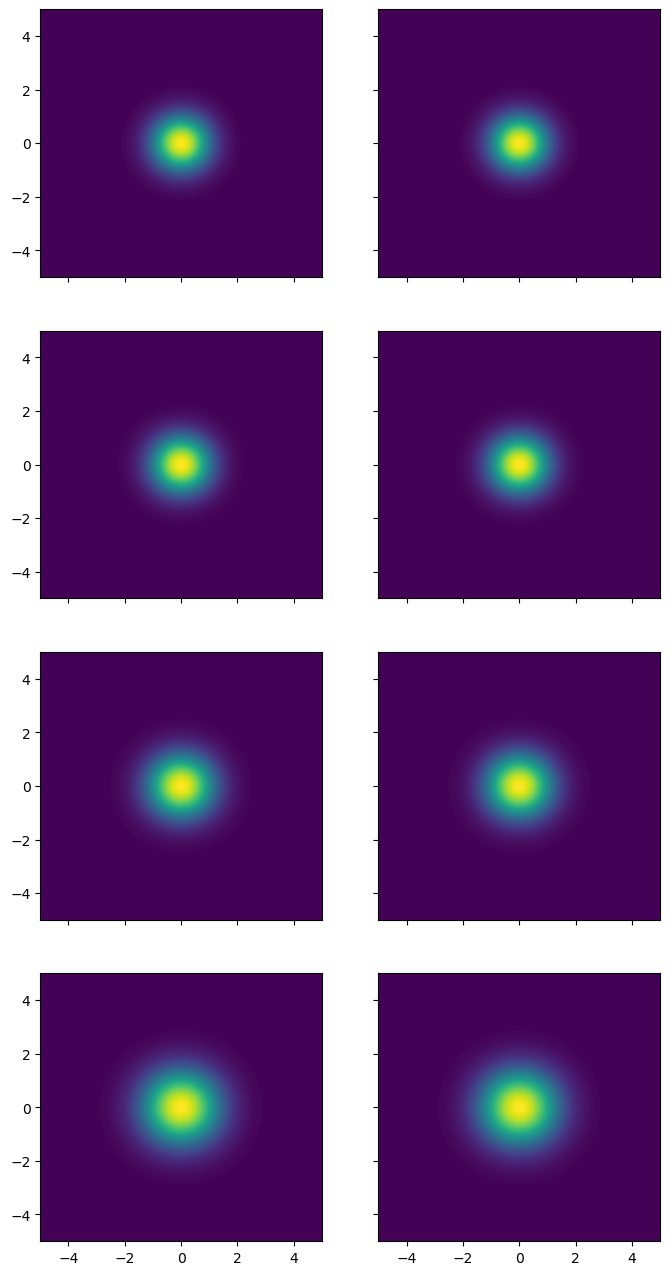

In [12]:
# pick an arbitrary time and calculate the wigner functions for each mode
xvec = np.linspace(-5, 5, 200)
t_idx_vec = [0, 10, 20, 30]

fig, axes = plt.subplots(
    len(t_idx_vec), 2, sharex=True, sharey=True,
    figsize=(8, 4 * len(t_idx_vec))
)

for idx, t_idx in enumerate(t_idx_vec):
    psi_a = ptrace(output.states[t_idx], 0)
    psi_b = ptrace(output.states[t_idx], 1)
    W_a = wigner(psi_a, xvec, xvec)
    W_b = wigner(psi_b, xvec, xvec)

    cont1 = axes[idx, 0].contourf(xvec, xvec, W_a, 100)
    cont2 = axes[idx, 1].contourf(xvec, xvec, W_b, 100)

Fock-state distribution
-----------------------


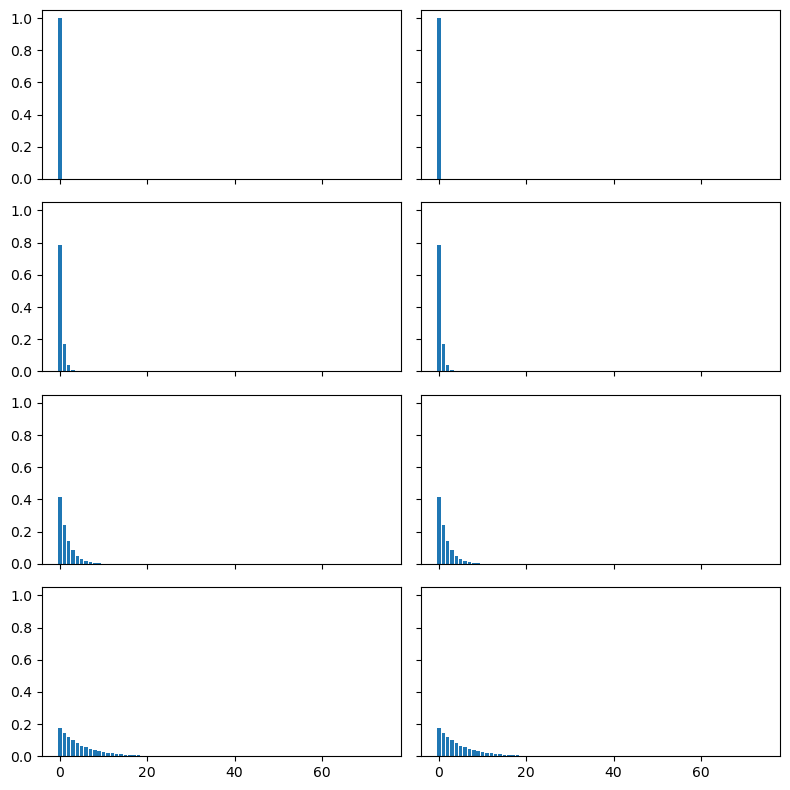

In [13]:
# pick arbitrary times and plot the photon distributions at those times
# t_idx_vec = [0, 10, 20, 30]
t_idx_vec = range(0, len(tlist), 25)

fig, axes = plt.subplots(
    len(t_idx_vec), 2, sharex=True, sharey=True,
    figsize=(8, 2 * len(t_idx_vec))
)

for idx, t_idx in enumerate(t_idx_vec):
    psi_a = ptrace(output.states[t_idx], 0)
    psi_b = ptrace(output.states[t_idx], 1)

    cont1 = axes[idx, 0].bar(range(0, N1), np.real(psi_a.diag()))
    cont2 = axes[idx, 1].bar(range(0, N2), np.real(psi_b.diag()))

fig.tight_layout()

## Nonclassical correlations

In [14]:
# second-order photon correlations
g2_1 = np.zeros(tlist.shape)
g2_2 = np.zeros(tlist.shape)
g2_12 = np.zeros(tlist.shape)

ad_ad_a_a = a.dag() * a.dag() * a * a
bd_bd_b_b = b.dag() * b.dag() * b * b
ad_a_bd_b = a.dag() * a * b.dag() * b

cs_rhs = np.zeros(tlist.shape)
cs_lhs = np.zeros(tlist.shape)

for idx, psi in enumerate(output.states):
    # g2 correlations
    g2_1[idx] = expect(ad_ad_a_a, psi)
    g2_2[idx] = expect(bd_bd_b_b, psi)
    g2_12[idx] = expect(ad_a_bd_b, psi)

    # cauchy-schwarz
    cs_lhs[idx] = expect(ad_a_bd_b, psi)
    cs_rhs[idx] = expect(ad_ad_a_a, psi)

# normalize the correlation functions
g2_1 = g2_1 / (na_e**2)
g2_2 = g2_2 / (nb_e**2)
g2_12 = g2_12 / (na_e * nb_e)

/tmp/ipykernel_7413/809448460.py:24: RuntimeWarning: invalid value encountered in divide
  g2_1 = g2_1 / (na_e**2)
/tmp/ipykernel_7413/809448460.py:25: RuntimeWarning: invalid value encountered in divide
  g2_2 = g2_2 / (nb_e**2)
/tmp/ipykernel_7413/809448460.py:26: RuntimeWarning: invalid value encountered in divide
  g2_12 = g2_12 / (na_e * nb_e)


### Second-order coherence functions: Cauchy-Schwarz inequality

Walls and Milburn, page 78: Classical states satisfy

$[g_{12}^{(2)}]^2 \leq g_{1}^{(2)}g_{2}^{(2)}$

(variant of the Cauchy-Schwarz inequality)

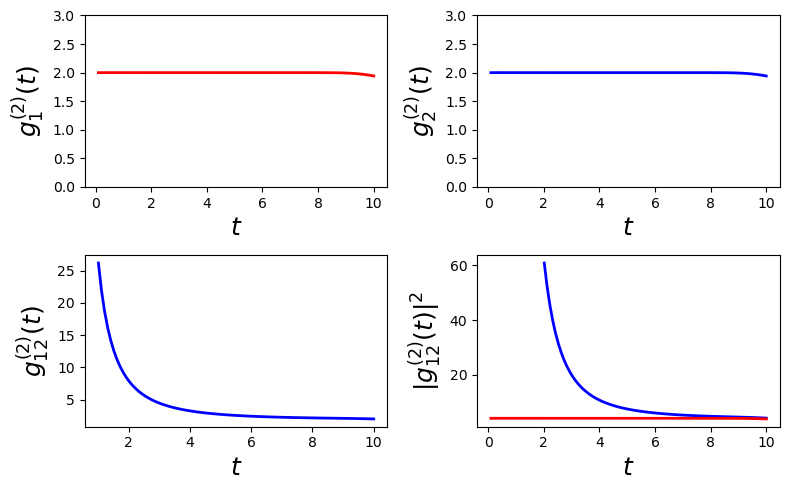

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

line1 = axes[0, 0].plot(tlist, g2_1, "r", linewidth=2)
axes[0, 0].set_xlabel("$t$", fontsize=18)
axes[0, 0].set_ylabel(r"$g_1^{(2)}(t)$", fontsize=18)
axes[0, 0].set_ylim(0, 3)

line2 = axes[0, 1].plot(tlist, g2_2, "b", linewidth=2)
axes[0, 1].set_xlabel("$t$", fontsize=18)
axes[0, 1].set_ylabel(r"$g_2^{(2)}(t)$", fontsize=18)
axes[0, 1].set_ylim(0, 3)

line3 = axes[1, 0].plot(tlist[10:], g2_12[10:], "b", linewidth=2)
axes[1, 0].set_xlabel("$t$", fontsize=18)
axes[1, 0].set_ylabel(r"$g_{12}^{(2)}(t)$", fontsize=18)


line4 = axes[1, 1].plot(tlist[20:], abs(g2_12[20:]) ** 2, "b", linewidth=2)
line5 = axes[1, 1].plot(tlist, g2_1 * g2_2, "r", linewidth=2)
axes[1, 1].set_xlabel("$t$", fontsize=18)
axes[1, 1].set_ylabel(r"$|g_{12}^{(2)}(t)|^2$", fontsize=18)

fig.tight_layout()

Clearly the two-mode squeezed state from the parameteric amplifier does not satisfy this inequality, and is therefore not classical.

Cauchy-Schwarz inequality
-------------------------

Walls and Milburn, page 78: the Cauchy-Schwarz inequality for symmetric modes

$\langle a^\dagger a b^\dagger b\rangle \leq \langle(a^\dagger)^2a^2\rangle$


/tmp/ipykernel_7413/3677191750.py:7: RuntimeWarning: invalid value encountered in divide
  line1 = axes[1].plot(tlist, cs_lhs / (cs_rhs), "k", linewidth=2)


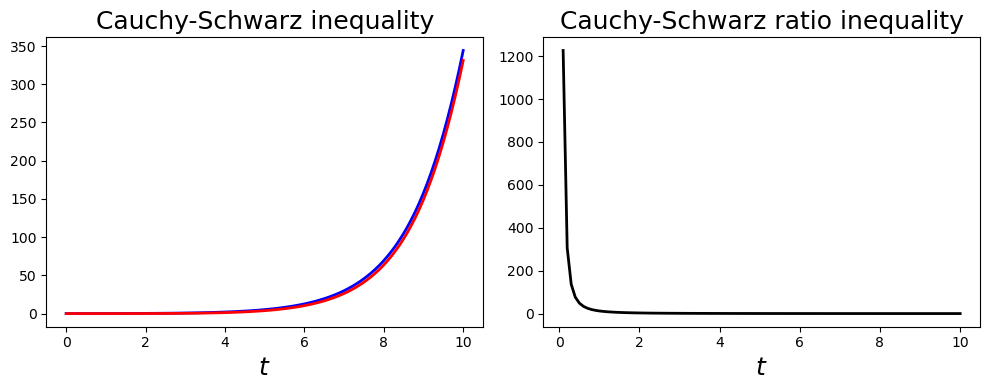

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

line1 = axes[0].plot(tlist, cs_lhs, "b", tlist, cs_rhs, "r", linewidth=2)
axes[0].set_xlabel("$t$", fontsize=18)
axes[0].set_title(r"Cauchy-Schwarz inequality", fontsize=18)

line1 = axes[1].plot(tlist, cs_lhs / (cs_rhs), "k", linewidth=2)
axes[1].set_xlabel("$t$", fontsize=18)
axes[1].set_title(r"Cauchy-Schwarz ratio inequality", fontsize=18)

fig.tight_layout()

Two-mode squeezing correlations
-------------------------------

The two-mode squeezing can be characterized by the parameter $\sigma_2$ defined as

$\sigma_2 = \frac{2\sqrt{\omega_a\omega_b}\left[\langle a b\rangle e^{i2\theta_\Sigma} + \langle a^\dagger b^\dagger\rangle e^{-i2\theta_\Sigma}\right]}{\omega_a\langle a^\dagger a + a a^\dagger \rangle +\omega_b\langle b^\dagger b + b b^\dagger \rangle}$



In [17]:
# pre-compute operators outside the loop
op_a_b = a * b
op_ad_bd = a.dag() * b.dag()
op_ad_a_p_a_ad = a.dag() * a + a * a.dag()
op_bd_b_p_b_bd = b.dag() * b + b * b.dag()

e_a_b = np.zeros(tlist.shape, dtype=complex)
e_ad_bd = np.zeros(tlist.shape, dtype=complex)
e_ad_a_p_a_ad = np.zeros(tlist.shape, dtype=complex)
e_bd_b_p_b_bd = np.zeros(tlist.shape, dtype=complex)

for idx, psi in enumerate(output.states):

    e_a_b[idx] = expect(op_a_b, psi)
    e_ad_bd[idx] = expect(op_ad_bd, psi)
    e_ad_a_p_a_ad[idx] = expect(op_ad_a_p_a_ad, psi)
    e_bd_b_p_b_bd[idx] = expect(op_bd_b_p_b_bd, psi)

# calculate the sigma_2
theta = 3 * np.pi / 4
w_a = w_b = 1
sigma2 = (
    2
    * np.sqrt(w_a * w_b)
    * (e_a_b * np.exp(2j * theta) + e_ad_bd * np.exp(-2j * theta))
    / (w_a * e_ad_a_p_a_ad + w_b * e_bd_b_p_b_bd)
)

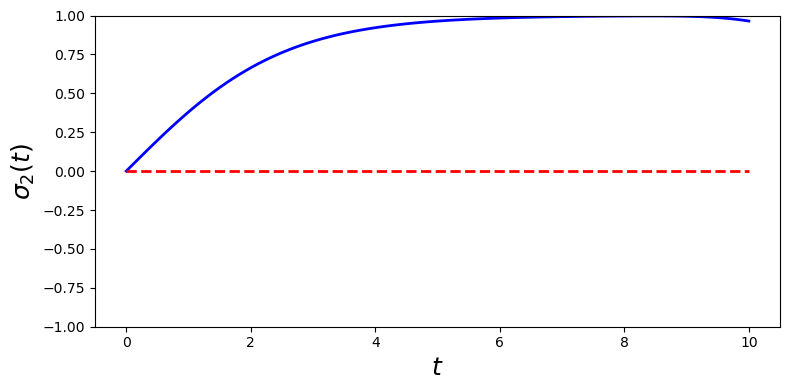

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

line1 = axes.plot(
    tlist, np.real(sigma2), "b", tlist, np.imag(sigma2), "r--", linewidth=2
)
axes.set_xlabel("$t$", fontsize=18)
axes.set_ylabel(r"$\sigma_2(t)$", fontsize=18)
axes.set_ylim(-1, 1)
fig.tight_layout()

Quantum-classical indicator $\langle:f^\dagger f:\rangle$
---------------------------------------------------------

Using $\langle:f^\dagger f:\rangle$ we can again show that the output of the parametric amplifier is nonclassical. If we choose

$f_\theta = e^{i\theta}b_- + e^{-i\theta}b_-^\dagger + ie^{i\theta}b_+ -i e^{-i\theta}b_+^\dagger$

we get

$F_\theta = \langle:f_\theta^\dagger f_\theta:\rangle = 2\langle a^\dagger a\rangle + 2\langle b^\dagger b\rangle + 2i\left(e^{2i\theta} \langle a b\rangle - e^{-2i\theta} \langle a^\dagger b^\dagger\rangle \right)$

In [19]:
# pre-compute operators outside the loop
op_ad_a = a.dag() * a
op_bd_b = b.dag() * b
op_a_b = a * b
op_ad_bd = a.dag() * b.dag()

e_ad_a = np.zeros(tlist.shape, dtype=complex)
e_bd_b = np.zeros(tlist.shape, dtype=complex)
e_a_b = np.zeros(tlist.shape, dtype=complex)
e_ad_bd = np.zeros(tlist.shape, dtype=complex)

for idx, psi in enumerate(output.states):

    e_ad_a[idx] = expect(op_ad_a, psi)
    e_bd_b[idx] = expect(op_bd_b, psi)
    e_a_b[idx] = expect(op_a_b, psi)
    e_ad_bd[idx] = expect(op_ad_bd, psi)

# calculate the sigma_2, function of the angle parameter theta


def F_theta(theta):
    return (
        2 * e_ad_a
        + 2 * e_bd_b
        + 2j * (np.exp(2j * theta) * e_a_b - np.exp(-2j * theta) * e_ad_bd)
    )

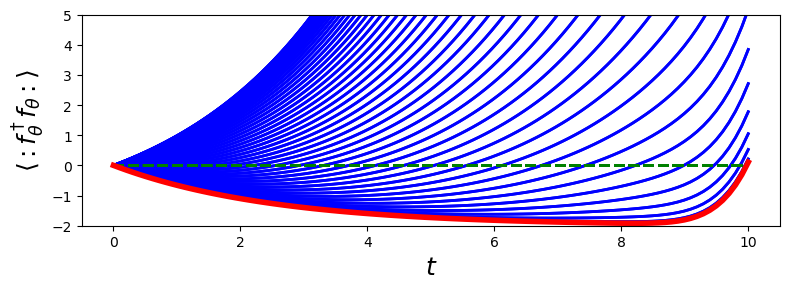

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(8, 3))

for theta in np.linspace(0.0, 2 * np.pi, 100):
    line1 = axes.plot(
        tlist,
        np.real(F_theta(theta)),
        "b",
        tlist,
        np.imag(F_theta(theta)),
        "g--",
        linewidth=2,
    )

line = axes.plot(tlist, np.real(F_theta(0)), "r", linewidth=4)

axes.set_xlabel("$t$", fontsize=18)
axes.set_ylabel(r"$\langle:f_\theta^\dagger f_\theta:\rangle$", fontsize=18)
axes.set_ylim(-2, 5)
fig.tight_layout()

Entanglement: logarithmic negativity
------------------------------------

#### Wigner covariance matrix:

In order to evaluate the logarithmic negativity we first need to construct the Wigner covariance matrix:

$V_{ij} = \frac{1}{2}\langle R_iR_j+R_jR_i \rangle$

where 

$R^T = (q_1, p_1, q_2, p_2) = (q_a, p_a, q_b, p_b)$

is a vector with the quadratures for the two modes $a$ and $b$:

$q_a = e^{i\theta_a}a + e^{-i\theta_a}a^\dagger$ 

$p_a = -i(e^{i\theta_a}a - e^{-i\theta_a}a^\dagger)$

and likewise for mode $b$.


In [21]:
R_op = correlation_matrix_quadrature(a, b)

In [22]:
def plot_covariance_matrix(V, ax):
    """
    Plot a matrix-histogram representation of the
    supplied Wigner covariance matrix.
    """
    num_elem = 16
    xpos, ypos = np.meshgrid(range(4), range(4))
    xpos = xpos.T.flatten() - 0.5
    ypos = ypos.T.flatten() - 0.5
    zpos = np.zeros(num_elem)
    dx = 0.75 * np.ones(num_elem)
    dy = dx.copy()
    dz = V.flatten()

    nrm = mpl.colors.Normalize(-0.5, 0.5)
    colors = cm.jet(nrm((np.sign(dz) * abs(dz) ** 0.75)))

    ax.view_init(azim=-40, elev=60)
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
    ax.axes.w_xaxis.set_major_locator(plt.IndexLocator(1, -0.5))
    ax.axes.w_yaxis.set_major_locator(plt.IndexLocator(1, -0.5))
    ax.axes.w_xaxis.set_ticklabels(("$q_-$", "$p_-$", "$q_+$", "$p_+$"),
                                   fontsize=20)
    ax.axes.w_yaxis.set_ticklabels(("$q_-$", "$p_-$", "$q_+$", "$p_+$"),
                                   fontsize=20)

/tmp/ipykernel_7413/1747935440.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.w_xaxis.set_ticklabels(("$q_-$", "$p_-$", "$q_+$", "$p_+$"),
/tmp/ipykernel_7413/1747935440.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.w_yaxis.set_ticklabels(("$q_-$", "$p_-$", "$q_+$", "$p_+$"),
/tmp/ipykernel_7413/4215878486.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


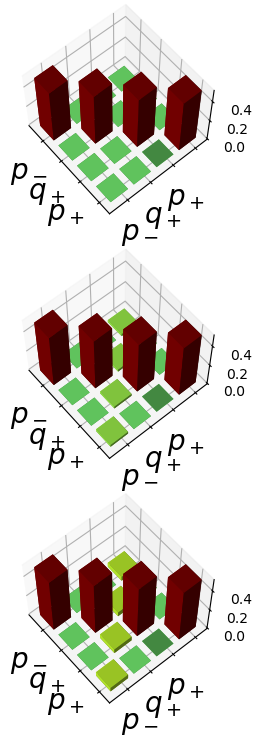

In [23]:
# pick arbitrary times and plot the photon distributions at those times
t_idx_vec = [0, 20, 40]

fig, axes = plt.subplots(
    len(t_idx_vec), 1, subplot_kw={"projection": "3d"},
    figsize=(6, 3 * len(t_idx_vec))
)

for idx, t_idx in enumerate(t_idx_vec):

    # calculate the wigner covariance matrix
    V = wigner_covariance_matrix(R=R_op, rho=output.states[idx])

    plot_covariance_matrix(V, axes[idx])

fig.tight_layout()

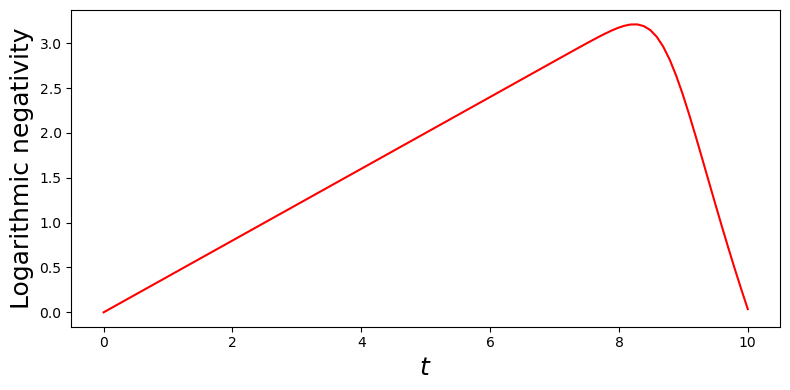

In [24]:
"""
Calculate the wigner covariance matrix logarithmic negativity
for each time step
"""
logneg = np.zeros(tlist.shape)

for idx, t_idx in enumerate(tlist):

    V = wigner_covariance_matrix(R=R_op, rho=output.states[idx])

    logneg[idx] = logarithmic_negativity(V)

fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(tlist, logneg, "r")
axes.set_xlabel("$t$", fontsize=18)
axes.set_ylabel("Logarithmic negativity", fontsize=18)
fig.tight_layout()

### Software versions:

In [25]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer